<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

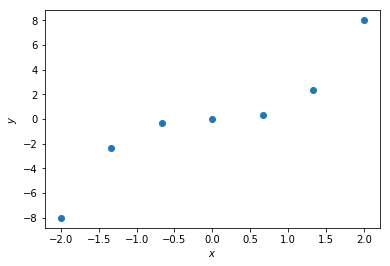

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Text(0,0.5,'$y$')

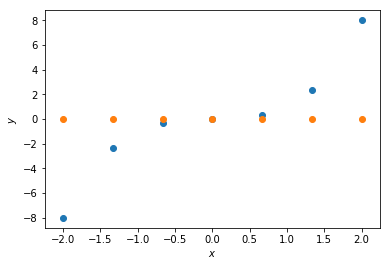

In [100]:
y1 = np.array([np.mean(y)]*y.size)

plt.scatter(X, y)
plt.scatter(X, y1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [94]:
# Ваш код здесь
def get_grid(data):
    x_min, x_max = data[0].min()-1, data[0].max()+1 
    y_min, y_max = data[1].min()-1, data[1].max()+1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
data = np.vstack((X,y))

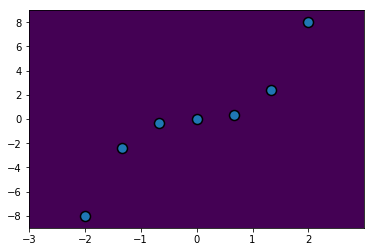

In [96]:
xx, yy = get_grid(data)
predict = xx**0
plt.pcolormesh(xx, yy, predict)
plt.scatter(data[0], data[1],  s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [97]:
data = pd.DataFrame(data)
data = data.T
data[data.loc[:,0]<0]

,0,1
0,-2.000000,-8.000000
1,-1.333333,-2.370370
2,-0.666667,-0.296296


In [98]:
predict = np.ones((xx.shape[0],xx.shape[1]))
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        if xx[i][j] < 0:
            predict[i][j]=0

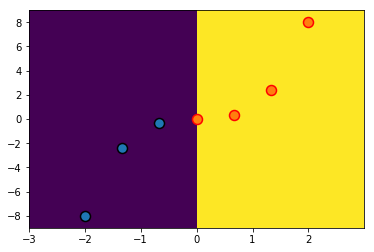

In [99]:
# Ваш код здесь
plt.pcolormesh(xx, yy, predict)
plt.scatter(data[0][data[0]<0], data[1][data[0]<0],  s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.scatter(data[0][data[0]>=0], data[1][data[0]>=0],  s=100, 
cmap='autumn', edgecolors='red', linewidth=1.5);
xx, yy = get_grid(data)



Text(0,0.5,'$y$')

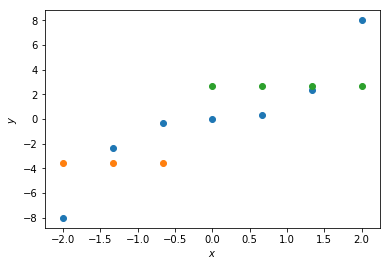

In [105]:
y1 = np.array([np.mean(data[1][data[0]<0])]*data[1][data[0]<0].shape[0])
y2 = np.array([np.mean(data[1][data[0]>=0])]*data[1][data[0]>=0].shape[0])
plt.scatter(X, y)
plt.scatter(data[0][data[0]<0], y1)
plt.scatter(data[0][data[0]>=0], y2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    pass

In [153]:
def var_(X,y):
    #if len(X)==0:
       # return(-1000000)
    var = 0
    for i in range(len(y)):
        var += (y[i] -(1/len(X))*sum(y))**2
    return (var*(1/len(X)))

In [161]:
# Ваш код здесь
t =np.linspace(-1.9,1.9,5)
def criterion(X,y,t):
    xr = []
    yr = []
    xl = []
    yl = []
    for i in range(len(X)):
        if X[i] < t :
            xl.append(X[i])
            yl.append(y[i])
        else:
            xr.append(X[i])
            yr.append(y[i])
    Q = var_(X,y) - (len(xr)/len(X))*var_(xr,yr) - (len(xl)/len(X))*var_(xl,yl)
    return Q

val = [ criterion(X,y,i) for i in t]

In [162]:
val,t

([10.666666666666664,
  10.754458161865568,
  9.481481481481481,
  10.754458161865568,
  10.666666666666666],
 array([-1.9 , -0.95,  0.  ,  0.95,  1.9 ]))

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

Text(0,0.5,'$y$')

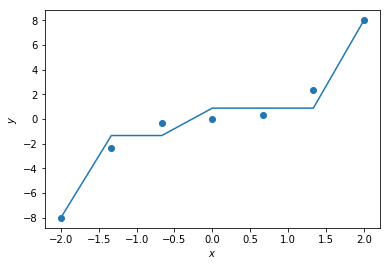

In [204]:
# Ваш код здесь
y1 = np.array([np.mean(data[1][data[0]<0])]*data[1][data[0]<0].shape[0])
y11 = np.array(data[1][data[0]<0])
y22 = np.array(data[1][data[0]>=0])
y2 = np.array([np.mean(data[1][data[0]>=0])]*data[1][data[0]>=0].shape[0])
x1 = data[0][data[0]<0]
x2= data[0][data[0]>=0]
y3 = np.array([np.mean(y11[x1<-1.5])]*y11[x1<-1.5].size + [np.mean(y11[x1>=-1.5])]*y11[x1>=-1.5].size+[np.mean(y22[x2<1.5])]*y22[x2<1.5].size + [np.mean(y22[x2>=1.5])]*y22[x2>=1.5].size)
plt.scatter(X, y)
plt.plot(X, np.array(y3))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [399]:
df = pd.read_csv('mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [400]:
# Ваш код здесь
df[['cholesterol_1','cholesterol_2','cholesterol_3']]=pd.get_dummies(df['cholesterol'], prefix = 'col')
df[['gluc_1','gluc_2','gluc_3']]=pd.get_dummies(df['gluc'], prefix = 'col')

In [401]:
import math

In [402]:
df['age_years'] = (df['age']/365.25).apply(lambda x: int(x))
df.head()
df = df.drop('age', axis =1)

In [403]:
#df = df.drop(['gluc','cholesterol'], axis = 1)
y = df['cardio']
df = df.drop('cardio', axis = 1)

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [352]:
X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, test_size=0.3,random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [290]:
# Ваш код здесь
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [291]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [292]:
export_graphviz(tree, feature_names=df.columns, 
out_file='tree.dot', filled=True)
!dot -Tpng 'tree.dot' -o 'tree.png'

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [293]:
# Ваш код здесь
y_pred = tree.predict(X_valid)

In [294]:
acc1 = accuracy_score(y_pred, y_valid)

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [295]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv = 5, n_jobs = -1, verbose = True)# Ваш код здесь

In [296]:
tree_grid.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [297]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 6}, 0.731938775510204)

In [298]:
y_pred = tree_grid.predict(X_valid)

In [299]:
acc2 = accuracy_score(y_pred, y_valid)

In [301]:
(acc2 - acc1) / acc1 * 100

0.6271869016967002

In [303]:
acc1, acc2

(0.7212857142857143, 0.7258095238095238)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [285]:
# Ваш код здесь
from sklearn.model_selection import cross_val_score
mean_ac =[]
for i in range(1,10):
    
    tree = DecisionTreeClassifier(max_depth=i, random_state=17)
    mean_ac.append(np.mean(cross_val_score(tree, X_train, y_train, cv = 5)))
                           


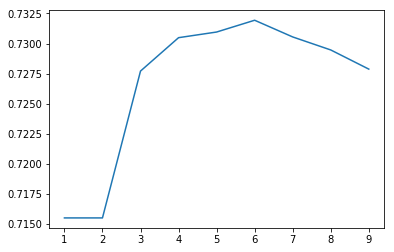

In [286]:
plt.plot(range(1,10), mean_ac)   

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [405]:
# Ваш код здесь
df['age_1'] = df['age_years'].apply(lambda x: 1 if (x >=45 and x<50) else 0)
df['age_2'] = df['age_years'].apply(lambda x: 1 if (x >=50 and x<55) else 0)
df['age_3'] = df['age_years'].apply(lambda x: 1 if (x >=55 and x<60) else 0)
df['age_4'] = df['age_years'].apply(lambda x: 1 if (x >=60 and x<65) else 0)
df['ap_hi_1'] = df['ap_hi'].apply(lambda x: 1 if (x >=120 and x<140) else 0)
df['ap_hi_2'] = df['ap_hi'].apply(lambda x: 1 if (x >=140 and x<160) else 0)
df['ap_hi_3'] = df['ap_hi'].apply(lambda x: 1 if (x >=160 and x<180) else 0)
df['gender'] = df['gender'].apply(lambda x: 0 if x == 2 else 1)

In [406]:
df.head()
df = df.drop(['height','weight', 'ap_hi','ap_lo','cholesterol','gluc'], axis =1)

In [408]:
df.head()

,gender,smoke,cholesterol_1,cholesterol_2,cholesterol_3,age_1,age_2,age_3,age_4,ap_hi_1,ap_hi_2,ap_hi_3
id,,,,,,,,,,,,
0,0,0,1,0,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,1,0,0,1,0
2,1,0,0,0,1,0,1,0,0,1,0,0
3,0,0,1,0,0,1,0,0,0,0,1,0
4,1,0,1,0,0,1,0,0,0,0,0,0


In [407]:
df = df.drop(['age_years','alco','active','gluc_1','gluc_2','gluc_3'],axis = 1)

In [409]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [410]:
tree.fit(df,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [411]:
export_graphviz(tree, feature_names=df.columns, 
out_file='tree.dot', filled=True)
!dot -Tpng 'tree.dot' -o 'tree.png'